# California Air Quality during the Thomas Fire in 2018
## EDS220 Final Project
https://github.com/shmuir/california-fire-AQI

# About

## Project Purpose
In December of 2017 the Thomas Fire spread across Santa Barbara and Ventura counties in California, burning nearly 282,000 acres. It damaged many natural and developed areas and was spead rapidly by strong winds. Air quality during the time of the fire was quite bad and many schools cancelled classes due to the air quality concerns, along with the power outages. 

## Highlighs of Analysis
In this project I will be: 

1. Fetching data from sources  
2. Visualizing the extent of the burn areas in Santa Barbara County in 2017
3. Analyzing the change in air quality in Santa Barbara County across 2017-2018. 

## About the Data

`ca_fires`: shapefile of fire perimeters in California for 2017

`landsat`: simplified collection of bands (red, green, blue, near-infrared and shortwave infrared)

`aqi_2017`: air quality index data from 2017

`aqi_2018`: air quality index data from 2018

## Data Sources

The Thomas fire shapefile was obtained from [California State Geoportal](https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about).

Santa Barbara landsat data was accessed and pre-processed in the Microsoft Planetary Computer to remove data outside land and coarsen the spatial resolution ([Landsat Collection in MPC](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2)).

The [Air Quality Index (AQI)](https://www.airnow.gov/aqi/aqi-basics/) was obtained from the [US Environmental Protection Agency](https://www.epa.gov).

# Importing the Data

The fire and landsat data is stored in a `data` folder which has been omitted from the GitHub repository due to the file sizes. 

In [1]:
# import libraries
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # for creating legends
import matplotlib.lines as mlines

import xarray as xr
import rioxarray as rioxr
from shapely.geometry import box
from shapely.geometry import Point

In [21]:
# california fires data
ca_fires = gpd.read_file(os.path.join(os.getcwd(), 'data', 'California_Fire_Perimeters_2017', 'California_Fire_Perimeters_2017.shp'))
# landsat data
landsat = rioxr.open_rasterio(os.path.join(os.getcwd(),'data','landsat8-2018-01-26-sb-simplified.nc'))

# air quality data
aqi_2017 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip")
aqi_2018 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip")

# Geographical Context of the Data

# Data Exploration

Let's start by looking at all of our loaded data and finding the CRS for those that are spatial data:

In [15]:
print(ca_fires.crs)
ca_fires.head(3)

epsg:3857


,index,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,...,GIS_ACRES,COMMENTS,COMPLEX_NA,COMPLEX_IN,IRWINID,FIRE_NUM,DECADES,SHAPE_Leng,SHAPE_Area,geometry
0,19836,41429,2017,CA,CCO,VNC,BROOK,00042450,2017-05-23,2017-05-24,...,10.043819,per walked track,None,None,None,None,2010,1246.055781,59473.666651,"POLYGON ((-13229812.974 4046876.486, -13229786..."
1,19837,41430,2017,CA,CCO,VNC,PACIFIC,00075307,2017-09-09,2017-09-09,...,1.190109,Final Walked track. Small spot to the north east,None,None,None,None,2010,561.418202,7081.369481,"POLYGON ((-13286872.985 4074523.355, -13286895..."
2,19838,41431,2017,CA,CCO,VNC,GRADE,00054660,2017-07-04,2017-07-05,...,47.194027,None,None,None,None,None,2010,2587.259697,279911.825212,"POLYGON ((-13244637.580 4056332.530, -13244620..."


In [13]:
print(landsat.rio.crs)
landsat

EPSG:32611


<xarray.Dataset>
Dimensions:      (y: 731, x: 870, band: 1)
Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * band         (band) int64 1
    spatial_ref  int64 0
Data variables:
    red          (band, y, x) float64 ...
    green        (band, y, x) float64 ...
    blue         (band, y, x) float64 ...
    nir08        (band, y, x) float64 ...
    swir22       (band, y, x) float64 ...

In [10]:
aqi_2017.head(3)

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2017-01-01,21,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2017-01-04,22,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,1,3,2017-01-10,19,Good,PM2.5,01-003-0010,1


In [11]:
aqi_2018.head(3)

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2018-01-02,32,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2018-01-05,34,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,1,3,2018-01-08,15,Good,PM2.5,01-003-0010,1


# Analysis

## Visualizing Raster Data

We want to look at the extent of the Thomas Fire in Santa Barbara County. We will do this by plotting the false color imagery from the landsat data and adding the fire borders from the California fires data. 

First we will need to prepare our data a bit more. From the data explortaion we can see that the landsat data has 'band' under coordinate which we will need to remove. 

In [26]:
# drop 'band' from landsat data
landsat = landsat.squeeze()
landsat = landsat.drop('band')

In [36]:
# check that 'band' has been dropped
print(landsat.dims, landsat.coords,'\n')

Frozen({'y': 731, 'x': 870}) Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
    spatial_ref  int64 0 



Secondly, we need the coordinate reference systems to match between the landsat and California fires data. 

In [37]:
ca_fires.crs == landsat.rio.crs

False

In [38]:
# update CRS of ca_fires to match the CRS of landsat
ca_fires = ca_fires.to_crs(landsat.rio.crs)
# check that they now match
ca_fires.crs == landsat.rio.crs

True

Finally our last step before plotting the data will be to clip the California fires data. It is currently for all of California, and we are just interested in Santa Barbara County. Fortunately, our landsat data is just for Santa Barbara County already, so we can use the extent of the landsat data to clip the fires data. 

In [61]:
# the second argument of gpd.clip takes the extent we want to clip to; in this case we will use the bounds of landsat
fires_clip = gpd.clip(ca_fires, landsat.rio.bounds())

Now we can plot our data!

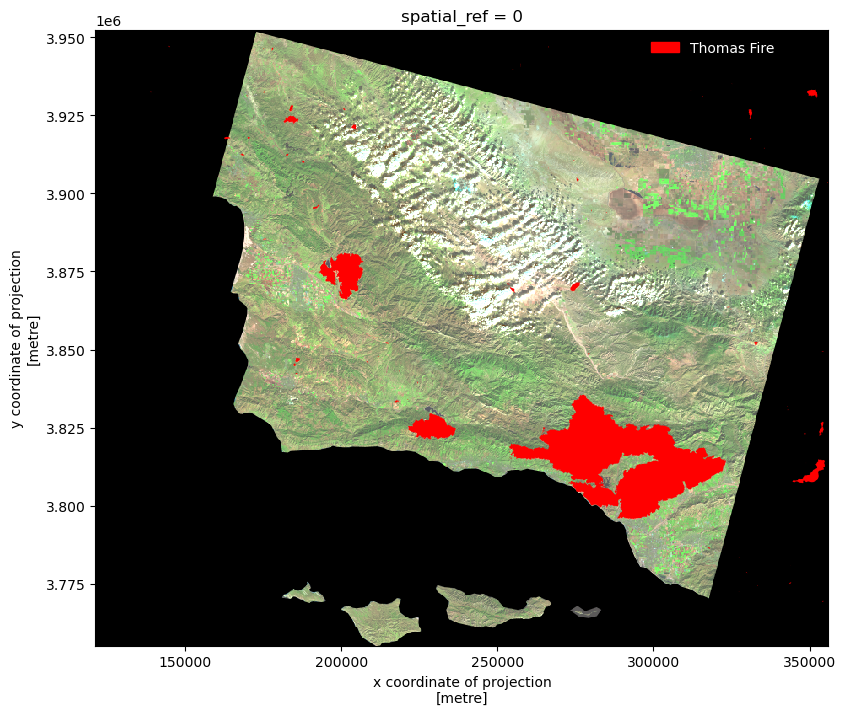

In [3]:
fig, ax = plt.subplots(figsize=(12,8)) # initialize plot

landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust=True, ax= ax) # landsat false image plot

fires_clip.plot(ax=ax, color = 'red') # plot thomas fire ontop of landsat image
fires_patch = mpatches.Patch(color='red', # change color to red
                          label='Thomas Fire') # update label

ax.legend(handles = [fires_patch], frameon=False, loc = (0.75, 0.95), labelcolor = 'white') # add legend and update text color

plt.show()

## Time-Series Analysis

Now that we have visualized the extent of the Thomas Fire in Santa Barbara County, we want to look at the change in air quality from before, during, and after the fire. The air quality index data is for all of the US, so we will need to select data for only Santa Barbara County. Additionally, we will calculate a 5 day rolling averge of the air quality index. 

First, we will combine the 2017 and 2018 dataframes.

In [65]:
# combine the two dataframes
aqi = pd.concat([aqi_17,aqi_18])

For ease of coding we will convert the column names to lower snake case using a string replace

In [67]:
# make the column names lower snake case
aqi.columns = aqi.columns.str.lower().str.replace(' ','_')
# check the column names
aqi.columns

Index(['state_name', 'county_name', 'state_code', 'county_code', 'date', 'aqi',
       'category', 'defining_parameter', 'defining_site',
       'number_of_sites_reporting'],
      dtype='object')

Currently this data is for all of the US so we need to filter to only have data for Santa Barbara County

In [89]:
# filter to only have SB county and drop other columns we don't need
aqi_sb = aqi[aqi['county_name'] == 'Santa Barbara'].drop(columns = ['state_name', 'county_name', 'state_code', 'county_code'])
# check the columns were dropped
aqi_sb.columns

Index(['date', 'aqi', 'category', 'defining_parameter', 'defining_site',
       'number_of_sites_reporting'],
      dtype='object')

In the data exploration, we can see that the date is an object instead of a datetime object, so we will need to update the date datatype. Additonally, we will then set the date as the index so we can calculate the 5-day rolling means. 

In [91]:
# data type of date
print("The data type of aqi_sb.date is:", aqi_sb.date.dtypes)

# make the date column a datetime instead of object data type
aqi_sb.date = pd.to_datetime(aqi_sb.date)
print("The new data type of aqi_sb.date is:", aqi_sb.date.dtypes)

# set the date to be the index
aqi_sb = aqi_sb.set_index('date')
# check the index was updated
aqi_sb.index

The data type of aqi_sb.date is: object
The new data type of aqi_sb.date is: datetime64[ns]


DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', name='date', length=730, freq=None)

In [93]:
# calculate rolling 5D means of the aqi as a new column in the df
aqi_sb['five_day_average'] = aqi_sb.aqi.rolling('5D').mean()

<AxesSubplot:title={'center':'Air Quality Index in Santa Barbara County 2017-2018'}, ylabel='Air Quality Index'>

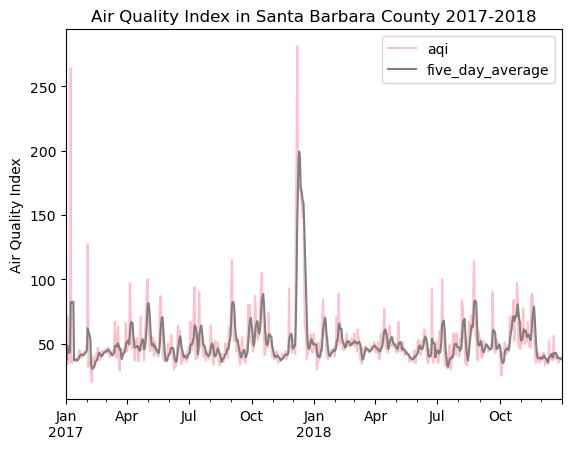

In [94]:
# plot the results of rolling means and the raw aqi
aqi_sb.plot(y = ['aqi', 'five_day_average'],# both on same axis
           kind = 'line', # line plot
           ylabel = 'Air Quality Index', # update label
            xlabel = '', # leave x-label blank
            color = ['pink', 'grey'], # update to more visible colors
           title = 'Air Quality Index in Santa Barbara County 2017-2018') # add a title

## References
